In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sciopy import EIT_16_32_64_128, EitMeasurementSetup
import matplotlib.pyplot as plt

In [2]:
# create a 'sciospec' class which represents the sciospec EIT device
n_el = 32
#64 
sciospec = EIT_16_32_64_128(n_el)

In [3]:
# connect device via USB-HS port
sciospec.connect_device_HS()

In [4]:
# read system message buffer
sciospec.SystemMessageCallback()
# should be empty

No message inside the message buffer
message buffer:
 []
message length:	 0


In [5]:
# create a measurement setup
setup = EitMeasurementSetup(
    burst_count=5,
    n_el=n_el,
    exc_freq=125_000,
    framerate=3,
    amplitude=0.01,
    inj_skip=n_el // 2,
    gain=1,
    adc_range=1,
)

In [6]:
sciospec.SetMeasurementSetup(setup)

Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4


In [7]:
# get data
data = sciospec.StartStopMeasurement(return_as="pot_mat")  # or "hex"  # kommt in for schleife 

In [8]:
data.shape   #mitteln, 1-4 burst count für training, und 5. für test for pot in data:

(5, 32, 32)

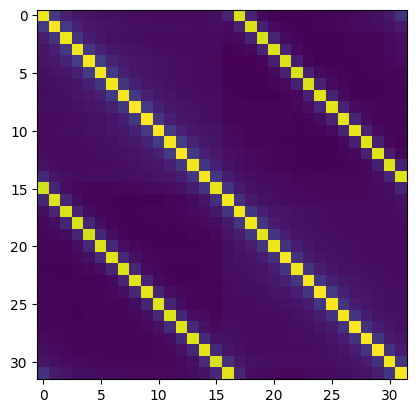

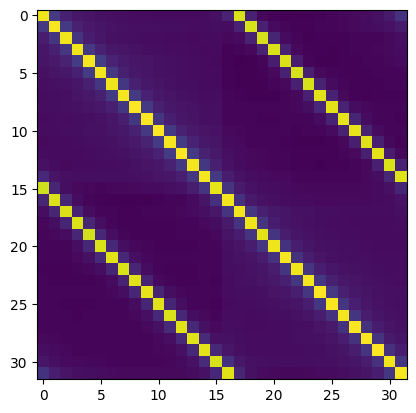

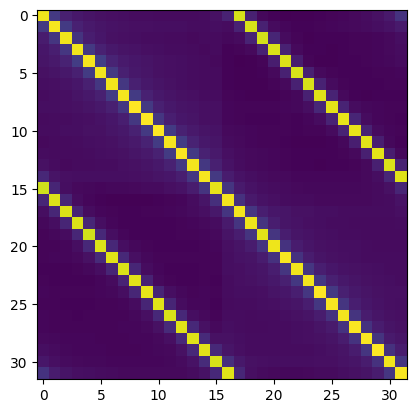

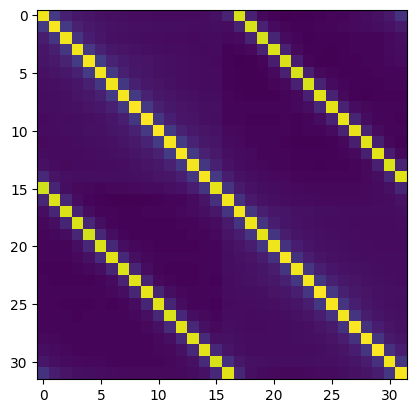

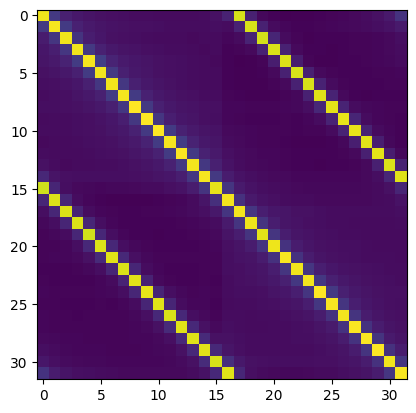

In [9]:
for pot in data:
    plt.imshow(np.abs(pot))
    plt.show()

In [10]:
import serial

from typing import Union
import time
from datetime import datetime
import numpy as np
import sys
import glob
from src.util import (
    create_trajectory,
    create_trajectory_3D
)
import os
from glob import glob
from tqdm import tqdm
# https://reprap.org/wiki/G-code#M17:_Enable.2FPower_all_stepper_motors

def command(ser, command) -> None:
    ser.write(str.encode(command))
    time.sleep(1)
    while True:
        line = ser.readline()
        print(line)

        if line == b"ok\n":
            break

# class
class EnderControl:
    def __init__(self,com_port, baudrate = 115200, timeout = 1, motion_speed = 1000):
        self.com_port = com_port
        self.baudrate = baudrate
        self.motion_speed = motion_speed # movement in mm/min
        self.position_timestamps = []  # Hier wird das Attribut position_timestamps korrekt initialisiert


    def connect(self):
        com = serial.Serial(
            port=self.com_port,
            baudrate=self.baudrate,
            parity=serial.PARITY_NONE,
            stopbits=serial.STOPBITS_ONE,
            bytesize=serial.EIGHTBITS,
        )
    
        print("Connection to", com.name, "is established.")
        self.com = com
        
    def init(self):
        """
        Initialise the axis
        """
        # x_y_home(ser)
        command(self.com, f"G28 X0 Y0 F{self.motion_speed}\r\n")
        command(self.com, f"G28 Z0 F{self.motion_speed}\r\n")
        self.x_y_center()
        self.turn_off_fan()
        print("X,Y axis are centered at X(180), Y(180)")

        return [180, 180]
    
    def turn_off_fan(self):
        command(self.com, "M106 S0\r\n")

    def x_y_center(self):
        command(self.com, f"G0 X180 Y180 F{self.motion_speed}\r\n")

    def move_to_absolute_x_y(self, P) -> None:
        command(
            self.com,
            f"G0 X{P[0]+180} Y{P[1]+180} F{self.motion_speed}\r\n",
        )
        pos = [P[0]+180, P[1]+180]
        return pos

    def move_to_absolute_x_y_z(self, P) -> None:
        command(
            self.com,
            f"G0 X{P[0]+180} Y{P[1]+180} Z{P[2]} F{self.motion_speed}\r\n",
        )
        pos = [P[0]+180, P[1]+180, P[2]]  #z im Bereich 50 bis 100 mm
        return pos

    def read_temperature(self) -> float:
        """
        Read the bed temperature of the Ender 5.
    
        This function sends the M105 command, which requests the current temperature.
    
        Returns
        -------
        float
            The bed temperature value.
        """
    
        self.com.write(str.encode(f"M105\r\n"))
        time.sleep(1)
        line = self.com.readline()
        temp = float(str(line).split("B:")[1].split(" ")[0])
        
        return temp

    def get_timestamp(self) -> str:
        """
        Returns the current timestamp in the format YYYY-MM-DD HH:MM:SS
        """
        current_time = datetime.now()  # Get the current date and time
        formatted_timestamp = current_time.strftime("%Y-%m-%d %H:%M:%S")  # Format the timestamp
        return current_time, formatted_timestamp

In [12]:
printer = EnderControl(com_port="/dev/ttyUSB0")
printer.connect()

Connection to /dev/ttyUSB0 is established.


## Initializing Printer ##

In [13]:
printer.init()

b'start\n'
b'echo: External Reset\n'
b'Marlin Ver 1.70.3 BL\n'
b'\n'
b'echo: Last Updated: 2022-02-24 | Author: Ender-5 Plus\n'
b'echo:Compiled: Feb 24 2022\n'
b'echo: Free Memory: 1406  PlannerBufferBytes: 1232\n'
b'echo:V42 stored settings retrieved (530 bytes; crc 12996)\n'
b'echo:  G21    ; Units in mm\n'
b'echo:  M149 C ; Units in Celsius\n'
b'\n'
b'echo:Filament settings: Disabled\n'
b'echo:  M200 D1.75\n'
b'echo:  M200 D0\n'
b'echo:Steps per unit:\n'
b'echo:  M92 X80.00 Y80.00 Z800.00 E92.60\n'
b'echo:Maximum feedrates (units/s):\n'
b'echo:  M203 X300.00 Y300.00 Z5.00 E25.00\n'
b'echo:Maximum Acceleration (units/s2):\n'
b'echo:  M201 X500 Y500 Z100 E1000\n'
b'echo:Acceleration (units/s2): P<print_accel> R<retract_accel> T<travel_accel>\n'
b'echo:  M204 P500.00 R500.00 T1000.00\n'
b'echo:Advanced: S<min_feedrate> T<min_travel_feedrate> B<min_segment_time_ms> X<max_xy_jerk> Z<max_z_jerk> E<max_e_jerk>\n'
b'echo:  M205 S0.00 T0.00 B20000 X10.00 Y10.00 Z0.40 E5.00\n'
b'echo:Home off

[180, 180]

## Generating and saving data ##

In [14]:
def generate_exp_data(traj, r_path, r_anomaly, material, empty_tank_pos, empty_tank_timestamp, empty_tank_machine_time, empty_tank_temp, empty_tank_data, base_points=500):

    #ref_radius = 0.2
    #scale_factor = r_path / ref_radius
    #scaled_points = int(round(base_points * scale_factor))
    #print(f"Generierte Punkte: {scaled_points} (Skalierung basierend auf r_path={r_path} und ref_radius={ref_radius})")
    #center_pos = create_trajectory(traj, r_path * 97, scaled_points)  # Trajektorie mit der skalierten Punktzahl
    center_pos = create_trajectory(traj, r_path * 97, base_points)
    base_dataset_folder = "exp_data_set"
    os.makedirs(base_dataset_folder, exist_ok=True)
    
    # Bestimme den Ordnernamen
    base_name = "exp_data"
    counter = 1
    folder_name = os.path.join(base_dataset_folder, base_name)
    while os.path.exists(folder_name):
        folder_name = os.path.join(base_dataset_folder, f"{base_name}{counter}")
        counter += 1
    os.makedirs(folder_name)
    
    # Logge die Parameter
    lookup = {
        "folder": folder_name,
        "Trajectory": traj,
        "Nsteps": base_points,
        "r_anomaly": r_anomaly,
        "r_path": r_path,
        "material": material,
    }

    lookup_file_path = os.path.join(base_dataset_folder, "exp_data_log.txt")
    with open(lookup_file_path, 'a') as f:
        for key, value in lookup.items():
            f.write(f"{key}: {value}\n")
        f.write("-" * 40 + "\n")

    # Speichere die leeren Tankmessungen als ersten Datensatz
    file_path = os.path.join(folder_name, "sample_000000.npz")
    np.savez(file_path, position=empty_tank_pos, timestamp=empty_tank_timestamp, 
             machine_time=empty_tank_machine_time, temperature=empty_tank_temp, v=empty_tank_data)
    
    for save_index, Ps in tqdm(enumerate(center_pos), total=len(center_pos)): 
        pos = printer.move_to_absolute_x_y(Ps)  
        temp = printer.read_temperature()  
        machine_time, timestamp = printer.get_timestamp()  
        data = sciospec.StartStopMeasurement(return_as="pot_mat")  
        
        # Speichere die Messung (Start bei sample_000001.npz)
        file_path = os.path.join(folder_name, f"sample_{save_index + 1:06d}.npz")
        np.savez(file_path, position=pos, timestamp=timestamp, machine_time=machine_time, 
                 temperature=temp, v=data)

    print("Measurement is complete!")


def generate_exp_data_3D(traj, r_path, r_anomaly, material, base_points=1000):
    ref_radius = 0.4
    scale_factor = r_path / ref_radius
    scaled_points = int(round(base_points * scale_factor))
    print(f"Generierte Punkte: {scaled_points} (Skalierung basierend auf r_path={r_path} und ref_radius={ref_radius})")
    fig = plt.figure(figsize=(20, 8))
    
    center_pos = create_trajectory_3D(traj, r_path*97, scaled_points)
    #print(center_pos)
    
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot(center_pos[:,0], center_pos[:,1], center_pos[:,2], color='red', label='Trajectory')
    ax1.scatter(center_pos[:, 0], center_pos[:, 1], center_pos[:, 2], color='blue', marker='o', s=1, label='Points')
    ax1.view_init(elev=90, azim=0)  # Top view
    ax1.set_title('Top View')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot(center_pos[:,0], center_pos[:,1], center_pos[:,2], color='red', label='Trajectory')
    ax2.scatter(center_pos[:, 0], center_pos[:, 1], center_pos[:, 2], color='blue', marker='o', s=1, label='Points')
    ax2.view_init(elev=0, azim=0)  # Side view
    ax2.set_title('Side View')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot(center_pos[:,0], center_pos[:,1], center_pos[:,2], color='red', label='Trajectory')
    ax3.scatter(center_pos[:, 0], center_pos[:, 1], center_pos[:, 2], color='blue', marker='o', s=1, label='Points')
    ax3.view_init(elev=45, azim=45)  # Isometric view
    ax3.set_title('Isometric View')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')

    plt.tight_layout()
    for ax in [ax1, ax2, ax3]:
        ax.legend()
    
    plt.show()

    base_dataset_folder = "exp_data_set_3D"
    os.makedirs(base_dataset_folder, exist_ok=True)
    
    # Bestimme den Ordnernamen
    base_name = "exp_data_3D"
    counter = 1
    folder_name = os.path.join(base_dataset_folder, base_name)
    while os.path.exists(folder_name):
        folder_name = os.path.join(base_dataset_folder, f"{base_name}{counter}")
        counter += 1
    os.makedirs(folder_name)
    
    # Logge die Parameter
    lookup = {
        "folder": folder_name,
        "Trajectory": traj,
        "Nsteps": scaled_points,
        "r_anomaly": r_anomaly,
        "r_path": r_path,
        "material": material,
    }

    lookup_file_path = os.path.join(base_dataset_folder, "exp_data_3D_log.txt")
    with open(lookup_file_path, 'a') as f:
        for key, value in lookup.items():
            f.write(f"{key}: {value}\n")
        f.write("-" * 40 + "\n")

#    # Speichere die leeren Tankmessungen als ersten Datensatz
#    file_path = os.path.join(folder_name, "sample_000000.npz")
#    empty_tank_pos = [180, 180, 50]
#    np.savez(file_path, position=empty_tank_pos, timestamp=empty_tank_timestamp, 
#             machine_time=empty_tank_machine_time, temperature=empty_tank_temp, v=empty_tank_data)
    
    for save_index, Ps in tqdm(enumerate(center_pos), total=len(center_pos)): 
        pos = printer.move_to_absolute_x_y_z(Ps)  
        temp = printer.read_temperature()  
        machine_time, timestamp = printer.get_timestamp()  
#        data = sciospec.StartStopMeasurement(return_as="pot_mat")  
        
        # Speichere die Messung (Start bei sample_000001.npz)
#        file_path = os.path.join(folder_name, f"sample_{save_index + 1:06d}.npz")
        file_path = os.path.join(folder_name, f"sample_{save_index:06d}.npz") 
        np.savez(file_path, position=pos, timestamp=timestamp, machine_time=machine_time, 
                 temperature=temp)
#        np.savez(file_path, position=pos, timestamp=timestamp, machine_time=machine_time, 
#                 temperature=temp, v=data)

    print("Measurement is complete!")

def empty_tank_measure():
#    """Erfasst die leeren Tankdaten."""
    pos = [180, 180]
    temp = printer.read_temperature()
    machine_time, timestamp = printer.get_timestamp()
    data = sciospec.StartStopMeasurement(return_as="pot_mat")
    return pos, timestamp, machine_time, temp, data

In [15]:
empty_tank_pos, empty_tank_timestamp, empty_tank_machine_time, empty_tank_temp, empty_tank_data = empty_tank_measure()

In [16]:
generate_exp_data(
    "Folium_rückwärts",           # Trajektorie
    0.75,              # r_path (Radius) 0.7, 0.6, 0.5, 0.4, 0.3, 0.2
    15,               # r_anomaly (Anomalieparameter)
    "Acryl Glas",     # Material
    empty_tank_pos,  
    empty_tank_timestamp,  
    empty_tank_machine_time,  
    empty_tank_temp,  
    empty_tank_data
)


  0%|                                                   | 0/500 [00:00<?, ?it/s]

b'ok\n'


  0%|                                           | 1/500 [00:04<37:35,  4.52s/it]

b'ok\n'


  0%|▏                                          | 2/500 [00:09<37:36,  4.53s/it]

b'ok\n'


  1%|▎                                          | 3/500 [00:13<37:35,  4.54s/it]

b'ok\n'


  1%|▎                                          | 4/500 [00:18<37:30,  4.54s/it]

b'ok\n'


  1%|▍                                          | 5/500 [00:22<37:27,  4.54s/it]

b'ok\n'


  1%|▌                                          | 6/500 [00:27<37:23,  4.54s/it]

b'ok\n'


  1%|▌                                          | 7/500 [00:31<37:19,  4.54s/it]

b'ok\n'


  2%|▋                                          | 8/500 [00:36<37:15,  4.54s/it]

b'ok\n'


  2%|▊                                          | 9/500 [00:40<37:10,  4.54s/it]

b'ok\n'


  2%|▊                                         | 10/500 [00:45<37:05,  4.54s/it]

b'ok\n'


  2%|▉                                         | 11/500 [00:49<37:01,  4.54s/it]

b'ok\n'


  2%|█                                         | 12/500 [00:54<36:56,  4.54s/it]

b'ok\n'


  3%|█                                         | 13/500 [00:59<36:51,  4.54s/it]

b'ok\n'


  3%|█▏                                        | 14/500 [01:03<36:43,  4.53s/it]

b'ok\n'


  3%|█▎                                        | 15/500 [01:08<36:40,  4.54s/it]

b'ok\n'


  3%|█▎                                        | 16/500 [01:12<36:34,  4.53s/it]

b'ok\n'


  3%|█▍                                        | 17/500 [01:17<36:31,  4.54s/it]

b'ok\n'


  4%|█▌                                        | 18/500 [01:21<36:27,  4.54s/it]

b'ok\n'


  4%|█▌                                        | 19/500 [01:26<36:18,  4.53s/it]

b'ok\n'


  4%|█▋                                        | 20/500 [01:30<36:16,  4.53s/it]

b'ok\n'


  4%|█▊                                        | 21/500 [01:35<36:08,  4.53s/it]

b'ok\n'


  4%|█▊                                        | 22/500 [01:39<36:05,  4.53s/it]

b'ok\n'


  5%|█▉                                        | 23/500 [01:44<35:58,  4.52s/it]

b'ok\n'


  5%|██                                        | 24/500 [01:48<35:55,  4.53s/it]

b'ok\n'


  5%|██                                        | 25/500 [01:53<35:54,  4.54s/it]

b'ok\n'


  5%|██▏                                       | 26/500 [01:57<35:50,  4.54s/it]

b'ok\n'


  5%|██▎                                       | 27/500 [02:02<35:47,  4.54s/it]

b'ok\n'


  6%|██▎                                       | 28/500 [02:07<35:42,  4.54s/it]

b'ok\n'


  6%|██▍                                       | 29/500 [02:11<35:38,  4.54s/it]

b'ok\n'


  6%|██▌                                       | 30/500 [02:16<35:34,  4.54s/it]

b'ok\n'


  6%|██▌                                       | 31/500 [02:20<35:27,  4.54s/it]

b'ok\n'


  6%|██▋                                       | 32/500 [02:25<35:23,  4.54s/it]

b'ok\n'


  7%|██▊                                       | 33/500 [02:29<35:20,  4.54s/it]

b'ok\n'


  7%|██▊                                       | 34/500 [02:34<35:14,  4.54s/it]

b'ok\n'


  7%|██▉                                       | 35/500 [02:38<35:11,  4.54s/it]

b'ok\n'


  7%|███                                       | 36/500 [02:43<35:05,  4.54s/it]

b'ok\n'


  7%|███                                       | 37/500 [02:47<34:56,  4.53s/it]

b'ok\n'


  8%|███▏                                      | 38/500 [02:52<34:49,  4.52s/it]

b'ok\n'


  8%|███▎                                      | 39/500 [02:56<34:47,  4.53s/it]

b'ok\n'


  8%|███▎                                      | 40/500 [03:01<34:45,  4.53s/it]

b'ok\n'


  8%|███▍                                      | 41/500 [03:05<34:41,  4.54s/it]

b'ok\n'


  8%|███▌                                      | 42/500 [03:10<34:37,  4.54s/it]

b'ok\n'


  9%|███▌                                      | 43/500 [03:15<34:34,  4.54s/it]

b'ok\n'


  9%|███▋                                      | 44/500 [03:19<34:30,  4.54s/it]

b'ok\n'


  9%|███▊                                      | 45/500 [03:24<34:25,  4.54s/it]

b'ok\n'


  9%|███▊                                      | 46/500 [03:28<34:18,  4.53s/it]

b'ok\n'


  9%|███▉                                      | 47/500 [03:33<34:14,  4.54s/it]

b'ok\n'


 10%|████                                      | 48/500 [03:37<34:11,  4.54s/it]

b'ok\n'


 10%|████                                      | 49/500 [03:42<34:05,  4.54s/it]

b'ok\n'


 10%|████▏                                     | 50/500 [03:46<34:02,  4.54s/it]

b'ok\n'


 10%|████▎                                     | 51/500 [03:51<33:57,  4.54s/it]

b'ok\n'


 10%|████▎                                     | 52/500 [03:55<33:53,  4.54s/it]

b'ok\n'


 11%|████▍                                     | 53/500 [04:00<33:49,  4.54s/it]

b'ok\n'


 11%|████▌                                     | 54/500 [04:04<33:42,  4.54s/it]

b'ok\n'


 11%|████▌                                     | 55/500 [04:09<33:39,  4.54s/it]

b'ok\n'


 11%|████▋                                     | 56/500 [04:14<33:34,  4.54s/it]

b'ok\n'


 11%|████▊                                     | 57/500 [04:18<33:27,  4.53s/it]

b'ok\n'


 12%|████▊                                     | 58/500 [04:23<33:24,  4.54s/it]

b'ok\n'


 12%|████▉                                     | 59/500 [04:27<33:15,  4.53s/it]

b'ok\n'


 12%|█████                                     | 60/500 [04:32<33:13,  4.53s/it]

b'ok\n'


 12%|█████                                     | 61/500 [04:36<33:03,  4.52s/it]

b'ok\n'


 12%|█████▏                                    | 62/500 [04:41<32:59,  4.52s/it]

b'ok\n'


 13%|█████▎                                    | 63/500 [04:45<32:53,  4.52s/it]

b'ok\n'


 13%|█████▍                                    | 64/500 [04:50<32:49,  4.52s/it]

b'ok\n'


 13%|█████▍                                    | 65/500 [04:54<32:47,  4.52s/it]

b'ok\n'


 13%|█████▌                                    | 66/500 [04:59<32:45,  4.53s/it]

b'ok\n'


 13%|█████▋                                    | 67/500 [05:03<32:42,  4.53s/it]

b'ok\n'


 14%|█████▋                                    | 68/500 [05:08<32:36,  4.53s/it]

b'ok\n'


 14%|█████▊                                    | 69/500 [05:12<32:32,  4.53s/it]

b'ok\n'


 14%|█████▉                                    | 70/500 [05:17<32:29,  4.53s/it]

b'ok\n'


 14%|█████▉                                    | 71/500 [05:21<32:25,  4.54s/it]

b'ok\n'


 14%|██████                                    | 72/500 [05:26<32:21,  4.54s/it]

b'ok\n'


 15%|██████▏                                   | 73/500 [05:31<32:15,  4.53s/it]

b'ok\n'


 15%|██████▏                                   | 74/500 [05:35<32:12,  4.54s/it]

b'ok\n'


 15%|██████▎                                   | 75/500 [05:40<32:08,  4.54s/it]

b'ok\n'


 15%|██████▍                                   | 76/500 [05:44<32:04,  4.54s/it]

b'ok\n'


 15%|██████▍                                   | 77/500 [05:49<31:56,  4.53s/it]

b'ok\n'


 16%|██████▌                                   | 78/500 [05:53<31:50,  4.53s/it]

b'ok\n'


 16%|██████▋                                   | 79/500 [05:58<31:47,  4.53s/it]

b'ok\n'


 16%|██████▋                                   | 80/500 [06:02<31:41,  4.53s/it]

b'ok\n'


 16%|██████▊                                   | 81/500 [06:07<31:39,  4.53s/it]

b'ok\n'


 16%|██████▉                                   | 82/500 [06:11<31:36,  4.54s/it]

b'ok\n'


 17%|██████▉                                   | 83/500 [06:16<31:28,  4.53s/it]

b'ok\n'


 17%|███████                                   | 84/500 [06:20<31:25,  4.53s/it]

b'ok\n'


 17%|███████▏                                  | 85/500 [06:25<31:21,  4.53s/it]

b'ok\n'


 17%|███████▏                                  | 86/500 [06:29<31:18,  4.54s/it]

b'ok\n'


 17%|███████▎                                  | 87/500 [06:34<31:14,  4.54s/it]

b'ok\n'


 18%|███████▍                                  | 88/500 [06:39<31:10,  4.54s/it]

b'ok\n'


 18%|███████▍                                  | 89/500 [06:43<31:07,  4.54s/it]

b'ok\n'


 18%|███████▌                                  | 90/500 [06:48<31:02,  4.54s/it]

b'ok\n'


 18%|███████▋                                  | 91/500 [06:52<30:57,  4.54s/it]

b'ok\n'


 18%|███████▋                                  | 92/500 [06:57<30:51,  4.54s/it]

b'ok\n'


 19%|███████▊                                  | 93/500 [07:01<30:44,  4.53s/it]

b'ok\n'


 19%|███████▉                                  | 94/500 [07:06<30:41,  4.54s/it]

b'ok\n'


 19%|███████▉                                  | 95/500 [07:10<30:38,  4.54s/it]

b'ok\n'


 19%|████████                                  | 96/500 [07:15<30:33,  4.54s/it]

b'ok\n'


 19%|████████▏                                 | 97/500 [07:19<30:29,  4.54s/it]

b'ok\n'


 20%|████████▏                                 | 98/500 [07:24<30:23,  4.54s/it]

b'ok\n'


 20%|████████▎                                 | 99/500 [07:28<30:19,  4.54s/it]

b'ok\n'


 20%|████████▏                                | 100/500 [07:33<30:15,  4.54s/it]

b'ok\n'


 20%|████████▎                                | 101/500 [07:38<30:11,  4.54s/it]

b'ok\n'


 20%|████████▎                                | 102/500 [07:42<30:06,  4.54s/it]

b'ok\n'


 21%|████████▍                                | 103/500 [07:47<30:02,  4.54s/it]

b'ok\n'


 21%|████████▌                                | 104/500 [07:51<29:57,  4.54s/it]

b'ok\n'


 21%|████████▌                                | 105/500 [07:56<29:53,  4.54s/it]

b'ok\n'


 21%|████████▋                                | 106/500 [08:00<29:49,  4.54s/it]

b'ok\n'


 21%|████████▊                                | 107/500 [08:05<29:44,  4.54s/it]

b'ok\n'


 22%|████████▊                                | 108/500 [08:09<29:38,  4.54s/it]

b'ok\n'


 22%|████████▉                                | 109/500 [08:14<29:34,  4.54s/it]

b'ok\n'


 22%|█████████                                | 110/500 [08:18<29:30,  4.54s/it]

b'ok\n'


 22%|█████████                                | 111/500 [08:23<29:24,  4.54s/it]

b'ok\n'


 22%|█████████▏                               | 112/500 [08:27<29:20,  4.54s/it]

b'ok\n'


 23%|█████████▎                               | 113/500 [08:32<29:16,  4.54s/it]

b'ok\n'


 23%|█████████▎                               | 114/500 [08:37<29:09,  4.53s/it]

b'ok\n'


 23%|█████████▍                               | 115/500 [08:41<29:05,  4.53s/it]

b'ok\n'


 23%|█████████▌                               | 116/500 [08:46<29:02,  4.54s/it]

b'ok\n'


 23%|█████████▌                               | 117/500 [08:50<28:55,  4.53s/it]

b'ok\n'


 24%|█████████▋                               | 118/500 [08:55<28:52,  4.54s/it]

b'ok\n'


 24%|█████████▊                               | 119/500 [08:59<28:48,  4.54s/it]

b'ok\n'


 24%|█████████▊                               | 120/500 [09:04<28:44,  4.54s/it]

b'ok\n'


 24%|█████████▉                               | 121/500 [09:08<28:38,  4.54s/it]

b'ok\n'


 24%|██████████                               | 122/500 [09:13<28:35,  4.54s/it]

b'ok\n'


 25%|██████████                               | 123/500 [09:17<28:31,  4.54s/it]

b'ok\n'


 25%|██████████▏                              | 124/500 [09:22<28:24,  4.53s/it]

b'ok\n'


 25%|██████████▎                              | 125/500 [09:26<28:20,  4.54s/it]

b'ok\n'


 25%|██████████▎                              | 126/500 [09:31<28:12,  4.53s/it]

b'ok\n'


 25%|██████████▍                              | 127/500 [09:36<28:10,  4.53s/it]

b'ok\n'


 26%|██████████▍                              | 128/500 [09:40<28:07,  4.54s/it]

b'ok\n'


 26%|██████████▌                              | 129/500 [09:45<28:03,  4.54s/it]

b'ok\n'


 26%|██████████▋                              | 130/500 [09:49<27:58,  4.54s/it]

b'ok\n'


 26%|██████████▋                              | 131/500 [09:54<27:54,  4.54s/it]

b'ok\n'


 26%|██████████▊                              | 132/500 [09:58<27:50,  4.54s/it]

b'ok\n'


 27%|██████████▉                              | 133/500 [10:03<27:46,  4.54s/it]

b'ok\n'


 27%|██████████▉                              | 134/500 [10:07<27:41,  4.54s/it]

b'ok\n'


 27%|███████████                              | 135/500 [10:12<27:37,  4.54s/it]

b'ok\n'


 27%|███████████▏                             | 136/500 [10:16<27:33,  4.54s/it]

b'ok\n'


 27%|███████████▏                             | 137/500 [10:21<27:28,  4.54s/it]

b'ok\n'


 28%|███████████▎                             | 138/500 [10:25<27:23,  4.54s/it]

b'ok\n'


 28%|███████████▍                             | 139/500 [10:30<27:15,  4.53s/it]

b'ok\n'


 28%|███████████▍                             | 140/500 [10:35<27:12,  4.53s/it]

b'ok\n'


 28%|███████████▌                             | 141/500 [10:39<27:08,  4.54s/it]

b'ok\n'


 28%|███████████▋                             | 142/500 [10:44<27:02,  4.53s/it]

b'ok\n'


 29%|███████████▋                             | 143/500 [10:48<26:59,  4.54s/it]

b'ok\n'


 29%|███████████▊                             | 144/500 [10:53<26:55,  4.54s/it]

b'ok\n'


 29%|███████████▉                             | 145/500 [10:57<26:51,  4.54s/it]

b'ok\n'


 29%|███████████▉                             | 146/500 [11:02<26:47,  4.54s/it]

b'ok\n'


 29%|████████████                             | 147/500 [11:06<26:43,  4.54s/it]

b'ok\n'


 30%|████████████▏                            | 148/500 [11:11<26:36,  4.54s/it]

b'ok\n'


 30%|████████████▏                            | 149/500 [11:15<26:30,  4.53s/it]

b'ok\n'


 30%|████████████▎                            | 150/500 [11:20<26:26,  4.53s/it]

b'ok\n'


 30%|████████████▍                            | 151/500 [11:24<26:23,  4.54s/it]

b'ok\n'


 30%|████████████▍                            | 152/500 [11:29<26:19,  4.54s/it]

b'ok\n'


 31%|████████████▌                            | 153/500 [11:33<26:14,  4.54s/it]

b'ok\n'


 31%|████████████▋                            | 154/500 [11:38<26:07,  4.53s/it]

b'ok\n'


 31%|████████████▋                            | 155/500 [11:43<26:04,  4.53s/it]

b'ok\n'


 31%|████████████▊                            | 156/500 [11:47<25:59,  4.53s/it]

b'ok\n'


 31%|████████████▊                            | 157/500 [11:52<25:55,  4.53s/it]

b'ok\n'


 32%|████████████▉                            | 158/500 [11:56<25:51,  4.54s/it]

b'ok\n'


 32%|█████████████                            | 159/500 [12:01<25:48,  4.54s/it]

b'ok\n'


 32%|█████████████                            | 160/500 [12:05<25:44,  4.54s/it]

b'ok\n'


 32%|█████████████▏                           | 161/500 [12:10<25:39,  4.54s/it]

b'ok\n'


 32%|█████████████▎                           | 162/500 [12:14<25:35,  4.54s/it]

b'ok\n'


 33%|█████████████▎                           | 163/500 [12:19<25:30,  4.54s/it]

b'ok\n'


 33%|█████████████▍                           | 164/500 [12:23<25:24,  4.54s/it]

b'ok\n'


 33%|█████████████▌                           | 165/500 [12:28<25:21,  4.54s/it]

b'ok\n'


 33%|█████████████▌                           | 166/500 [12:32<25:16,  4.54s/it]

b'ok\n'


 33%|█████████████▋                           | 167/500 [12:37<25:09,  4.53s/it]

b'ok\n'


 34%|█████████████▊                           | 168/500 [12:42<25:05,  4.53s/it]

b'ok\n'


 34%|█████████████▊                           | 169/500 [12:46<24:58,  4.53s/it]

b'ok\n'


 34%|█████████████▉                           | 170/500 [12:51<24:55,  4.53s/it]

b'ok\n'


 34%|██████████████                           | 171/500 [12:55<24:52,  4.54s/it]

b'ok\n'


 34%|██████████████                           | 172/500 [13:00<24:48,  4.54s/it]

b'ok\n'


 35%|██████████████▏                          | 173/500 [13:04<24:41,  4.53s/it]

b'ok\n'


 35%|██████████████▎                          | 174/500 [13:09<24:34,  4.52s/it]

b'ok\n'


 35%|██████████████▎                          | 175/500 [13:13<24:32,  4.53s/it]

b'ok\n'


 35%|██████████████▍                          | 176/500 [13:18<24:28,  4.53s/it]

b'ok\n'


 35%|██████████████▌                          | 177/500 [13:22<24:25,  4.54s/it]

b'ok\n'


 36%|██████████████▌                          | 178/500 [13:27<24:21,  4.54s/it]

b'ok\n'


 36%|██████████████▋                          | 179/500 [13:31<24:14,  4.53s/it]

b'ok\n'


 36%|██████████████▊                          | 180/500 [13:36<24:10,  4.53s/it]

b'ok\n'


 36%|██████████████▊                          | 181/500 [13:40<24:06,  4.54s/it]

b'ok\n'


 36%|██████████████▉                          | 182/500 [13:45<24:03,  4.54s/it]

b'ok\n'


 37%|███████████████                          | 183/500 [13:50<23:58,  4.54s/it]

b'ok\n'


 37%|███████████████                          | 184/500 [13:54<23:52,  4.53s/it]

b'ok\n'


 37%|███████████████▏                         | 185/500 [13:59<23:48,  4.53s/it]

b'ok\n'


 37%|███████████████▎                         | 186/500 [14:03<23:41,  4.53s/it]

b'ok\n'


 37%|███████████████▎                         | 187/500 [14:08<23:38,  4.53s/it]

b'ok\n'


 38%|███████████████▍                         | 188/500 [14:12<23:34,  4.53s/it]

b'ok\n'


 38%|███████████████▍                         | 189/500 [14:17<23:30,  4.54s/it]

b'ok\n'


 38%|███████████████▌                         | 190/500 [14:21<23:26,  4.54s/it]

b'ok\n'


 38%|███████████████▋                         | 191/500 [14:26<23:22,  4.54s/it]

b'ok\n'


 38%|███████████████▋                         | 192/500 [14:30<23:18,  4.54s/it]

b'ok\n'


 39%|███████████████▊                         | 193/500 [14:35<23:13,  4.54s/it]

b'ok\n'


 39%|███████████████▉                         | 194/500 [14:39<23:09,  4.54s/it]

b'ok\n'


 39%|███████████████▉                         | 195/500 [14:44<23:05,  4.54s/it]

b'ok\n'


 39%|████████████████                         | 196/500 [14:49<23:00,  4.54s/it]

b'ok\n'


 39%|████████████████▏                        | 197/500 [14:53<22:54,  4.53s/it]

b'ok\n'


 40%|████████████████▏                        | 198/500 [14:58<22:50,  4.54s/it]

b'ok\n'


 40%|████████████████▎                        | 199/500 [15:02<22:43,  4.53s/it]

b'ok\n'


 40%|████████████████▍                        | 200/500 [15:07<22:39,  4.53s/it]

b'ok\n'


 40%|████████████████▍                        | 201/500 [15:11<22:32,  4.52s/it]

b'ok\n'


 40%|████████████████▌                        | 202/500 [15:16<22:30,  4.53s/it]

b'ok\n'


 41%|████████████████▋                        | 203/500 [15:20<22:26,  4.53s/it]

b'ok\n'


 41%|████████████████▋                        | 204/500 [15:25<22:22,  4.54s/it]

b'ok\n'


 41%|████████████████▊                        | 205/500 [15:29<22:18,  4.54s/it]

b'ok\n'


 41%|████████████████▉                        | 206/500 [15:34<22:14,  4.54s/it]

b'ok\n'


 41%|████████████████▉                        | 207/500 [15:38<22:10,  4.54s/it]

b'ok\n'


 42%|█████████████████                        | 208/500 [15:43<22:02,  4.53s/it]

b'ok\n'


 42%|█████████████████▏                       | 209/500 [15:47<21:59,  4.54s/it]

b'ok\n'


 42%|█████████████████▏                       | 210/500 [15:52<21:56,  4.54s/it]

b'ok\n'


 42%|█████████████████▎                       | 211/500 [15:57<21:50,  4.53s/it]

b'ok\n'


 42%|█████████████████▍                       | 212/500 [16:01<21:46,  4.54s/it]

b'ok\n'


 43%|█████████████████▍                       | 213/500 [16:06<21:42,  4.54s/it]

b'ok\n'


 43%|█████████████████▌                       | 214/500 [16:10<21:36,  4.53s/it]

b'ok\n'


 43%|█████████████████▋                       | 215/500 [16:15<21:32,  4.54s/it]

b'ok\n'


 43%|█████████████████▋                       | 216/500 [16:19<21:28,  4.54s/it]

b'ok\n'


 43%|█████████████████▊                       | 217/500 [16:24<21:24,  4.54s/it]

b'ok\n'


 44%|█████████████████▉                       | 218/500 [16:28<21:20,  4.54s/it]

b'ok\n'


 44%|█████████████████▉                       | 219/500 [16:33<21:15,  4.54s/it]

b'ok\n'


 44%|██████████████████                       | 220/500 [16:37<21:09,  4.53s/it]

b'ok\n'


 44%|██████████████████                       | 221/500 [16:42<21:05,  4.54s/it]

b'ok\n'


 44%|██████████████████▏                      | 222/500 [16:46<21:01,  4.54s/it]

b'ok\n'


 45%|██████████████████▎                      | 223/500 [16:51<20:57,  4.54s/it]

b'ok\n'


 45%|██████████████████▎                      | 224/500 [16:56<20:51,  4.53s/it]

b'ok\n'


 45%|██████████████████▍                      | 225/500 [17:00<20:47,  4.54s/it]

b'ok\n'


 45%|██████████████████▌                      | 226/500 [17:05<20:43,  4.54s/it]

b'ok\n'


 45%|██████████████████▌                      | 227/500 [17:09<20:37,  4.53s/it]

b'ok\n'


 46%|██████████████████▋                      | 228/500 [17:14<20:33,  4.54s/it]

b'ok\n'


 46%|██████████████████▊                      | 229/500 [17:18<20:29,  4.54s/it]

b'ok\n'


 46%|██████████████████▊                      | 230/500 [17:23<20:24,  4.54s/it]

b'ok\n'


 46%|██████████████████▉                      | 231/500 [17:27<20:20,  4.54s/it]

b'ok\n'


 46%|███████████████████                      | 232/500 [17:32<20:16,  4.54s/it]

b'ok\n'


 47%|███████████████████                      | 233/500 [17:36<20:12,  4.54s/it]

b'ok\n'


 47%|███████████████████▏                     | 234/500 [17:41<20:07,  4.54s/it]

b'ok\n'


 47%|███████████████████▎                     | 235/500 [17:45<20:03,  4.54s/it]

b'ok\n'


 47%|███████████████████▎                     | 236/500 [17:50<19:58,  4.54s/it]

b'ok\n'


 47%|███████████████████▍                     | 237/500 [17:55<19:52,  4.53s/it]

b'ok\n'


 48%|███████████████████▌                     | 238/500 [17:59<19:48,  4.54s/it]

b'ok\n'


 48%|███████████████████▌                     | 239/500 [18:04<19:44,  4.54s/it]

b'ok\n'


 48%|███████████████████▋                     | 240/500 [18:08<19:40,  4.54s/it]

b'ok\n'


 48%|███████████████████▊                     | 241/500 [18:13<19:35,  4.54s/it]

b'ok\n'


 48%|███████████████████▊                     | 242/500 [18:17<19:28,  4.53s/it]

b'ok\n'


 49%|███████████████████▉                     | 243/500 [18:22<19:25,  4.53s/it]

b'ok\n'


 49%|████████████████████                     | 244/500 [18:26<19:21,  4.54s/it]

b'ok\n'


 49%|████████████████████                     | 245/500 [18:31<19:17,  4.54s/it]

b'ok\n'


 49%|████████████████████▏                    | 246/500 [18:35<19:13,  4.54s/it]

b'ok\n'


 49%|████████████████████▎                    | 247/500 [18:40<19:08,  4.54s/it]

b'ok\n'


 50%|████████████████████▎                    | 248/500 [18:44<19:04,  4.54s/it]

b'ok\n'


 50%|████████████████████▍                    | 249/500 [18:49<18:59,  4.54s/it]

b'ok\n'


 50%|████████████████████▌                    | 250/500 [18:53<18:52,  4.53s/it]

b'ok\n'


 50%|████████████████████▌                    | 251/500 [18:58<18:48,  4.53s/it]

b'ok\n'


 50%|████████████████████▋                    | 252/500 [19:03<18:44,  4.54s/it]

b'ok\n'


 51%|████████████████████▋                    | 253/500 [19:07<18:40,  4.54s/it]

b'ok\n'


 51%|████████████████████▊                    | 254/500 [19:12<18:36,  4.54s/it]

b'ok\n'


 51%|████████████████████▉                    | 255/500 [19:16<18:31,  4.54s/it]

b'ok\n'


 51%|████████████████████▉                    | 256/500 [19:21<18:26,  4.54s/it]

b'ok\n'


 51%|█████████████████████                    | 257/500 [19:25<18:21,  4.53s/it]

b'ok\n'


 52%|█████████████████████▏                   | 258/500 [19:30<18:18,  4.54s/it]

b'ok\n'


 52%|█████████████████████▏                   | 259/500 [19:34<18:13,  4.54s/it]

b'ok\n'


 52%|█████████████████████▎                   | 260/500 [19:39<18:08,  4.54s/it]

b'ok\n'


 52%|█████████████████████▍                   | 261/500 [19:43<18:04,  4.54s/it]

b'ok\n'


 52%|█████████████████████▍                   | 262/500 [19:48<18:00,  4.54s/it]

b'ok\n'


 53%|█████████████████████▌                   | 263/500 [19:52<17:56,  4.54s/it]

b'ok\n'


 53%|█████████████████████▋                   | 264/500 [19:57<17:52,  4.54s/it]

b'ok\n'


 53%|█████████████████████▋                   | 265/500 [20:02<17:45,  4.54s/it]

b'ok\n'


 53%|█████████████████████▊                   | 266/500 [20:06<17:41,  4.54s/it]

b'ok\n'


 53%|█████████████████████▉                   | 267/500 [20:11<17:37,  4.54s/it]

b'ok\n'


 54%|█████████████████████▉                   | 268/500 [20:15<17:32,  4.54s/it]

b'ok\n'


 54%|██████████████████████                   | 269/500 [20:20<17:28,  4.54s/it]

b'ok\n'


 54%|██████████████████████▏                  | 270/500 [20:24<17:23,  4.53s/it]

b'ok\n'


 54%|██████████████████████▏                  | 271/500 [20:29<17:18,  4.54s/it]

b'ok\n'


 54%|██████████████████████▎                  | 272/500 [20:33<17:15,  4.54s/it]

b'ok\n'


 55%|██████████████████████▍                  | 273/500 [20:38<17:10,  4.54s/it]

b'ok\n'


 55%|██████████████████████▍                  | 274/500 [20:42<17:06,  4.54s/it]

b'ok\n'


 55%|██████████████████████▌                  | 275/500 [20:47<17:01,  4.54s/it]

b'ok\n'


 55%|██████████████████████▋                  | 276/500 [20:51<16:57,  4.54s/it]

b'ok\n'


 55%|██████████████████████▋                  | 277/500 [20:56<16:52,  4.54s/it]

b'ok\n'


 56%|██████████████████████▊                  | 278/500 [21:01<16:46,  4.54s/it]

b'ok\n'


 56%|██████████████████████▉                  | 279/500 [21:05<16:42,  4.54s/it]

b'ok\n'


 56%|██████████████████████▉                  | 280/500 [21:10<16:38,  4.54s/it]

b'ok\n'


 56%|███████████████████████                  | 281/500 [21:14<16:34,  4.54s/it]

b'ok\n'


 56%|███████████████████████                  | 282/500 [21:19<16:29,  4.54s/it]

b'ok\n'


 57%|███████████████████████▏                 | 283/500 [21:23<16:23,  4.53s/it]

b'ok\n'


 57%|███████████████████████▎                 | 284/500 [21:28<16:19,  4.53s/it]

b'ok\n'


 57%|███████████████████████▎                 | 285/500 [21:32<16:15,  4.54s/it]

b'ok\n'


 57%|███████████████████████▍                 | 286/500 [21:37<16:10,  4.54s/it]

b'ok\n'


 57%|███████████████████████▌                 | 287/500 [21:41<16:06,  4.54s/it]

b'ok\n'


 58%|███████████████████████▌                 | 288/500 [21:46<16:02,  4.54s/it]

b'ok\n'


 58%|███████████████████████▋                 | 289/500 [21:50<15:58,  4.54s/it]

b'ok\n'


 58%|███████████████████████▊                 | 290/500 [21:55<15:50,  4.52s/it]

b'ok\n'


 58%|███████████████████████▊                 | 291/500 [22:00<15:46,  4.53s/it]

b'ok\n'


 58%|███████████████████████▉                 | 292/500 [22:04<15:42,  4.53s/it]

b'ok\n'


 59%|████████████████████████                 | 293/500 [22:09<15:37,  4.53s/it]

b'ok\n'


 59%|████████████████████████                 | 294/500 [22:13<15:34,  4.53s/it]

b'ok\n'


 59%|████████████████████████▏                | 295/500 [22:18<15:30,  4.54s/it]

b'ok\n'


 59%|████████████████████████▎                | 296/500 [22:22<15:26,  4.54s/it]

b'ok\n'


 59%|████████████████████████▎                | 297/500 [22:27<15:21,  4.54s/it]

b'ok\n'


 60%|████████████████████████▍                | 298/500 [22:31<15:15,  4.53s/it]

b'ok\n'


 60%|████████████████████████▌                | 299/500 [22:36<15:11,  4.53s/it]

b'ok\n'


 60%|████████████████████████▌                | 300/500 [22:40<15:07,  4.54s/it]

b'ok\n'


 60%|████████████████████████▋                | 301/500 [22:45<15:03,  4.54s/it]

b'ok\n'


 60%|████████████████████████▊                | 302/500 [22:49<14:58,  4.54s/it]

b'ok\n'


 61%|████████████████████████▊                | 303/500 [22:54<14:54,  4.54s/it]

b'ok\n'


 61%|████████████████████████▉                | 304/500 [22:59<14:49,  4.54s/it]

b'ok\n'


 61%|█████████████████████████                | 305/500 [23:03<14:45,  4.54s/it]

b'ok\n'


 61%|█████████████████████████                | 306/500 [23:08<14:40,  4.54s/it]

b'ok\n'


 61%|█████████████████████████▏               | 307/500 [23:12<14:36,  4.54s/it]

b'ok\n'


 62%|█████████████████████████▎               | 308/500 [23:17<14:31,  4.54s/it]

b'ok\n'


 62%|█████████████████████████▎               | 309/500 [23:21<14:26,  4.54s/it]

b'ok\n'


 62%|█████████████████████████▍               | 310/500 [23:26<14:21,  4.53s/it]

b'ok\n'


 62%|█████████████████████████▌               | 311/500 [23:30<14:16,  4.53s/it]

b'ok\n'


 62%|█████████████████████████▌               | 312/500 [23:35<14:12,  4.54s/it]

b'ok\n'


 63%|█████████████████████████▋               | 313/500 [23:39<14:07,  4.53s/it]

b'ok\n'


 63%|█████████████████████████▋               | 314/500 [23:44<14:03,  4.53s/it]

b'ok\n'


 63%|█████████████████████████▊               | 315/500 [23:48<13:59,  4.54s/it]

b'ok\n'


 63%|█████████████████████████▉               | 316/500 [23:53<13:55,  4.54s/it]

b'ok\n'


 63%|█████████████████████████▉               | 317/500 [23:57<13:49,  4.53s/it]

b'ok\n'


 64%|██████████████████████████               | 318/500 [24:02<13:45,  4.53s/it]

b'ok\n'


 64%|██████████████████████████▏              | 319/500 [24:07<13:41,  4.54s/it]

b'ok\n'


 64%|██████████████████████████▏              | 320/500 [24:11<13:36,  4.54s/it]

b'ok\n'


 64%|██████████████████████████▎              | 321/500 [24:16<13:32,  4.54s/it]

b'ok\n'


 64%|██████████████████████████▍              | 322/500 [24:20<13:28,  4.54s/it]

b'ok\n'


 65%|██████████████████████████▍              | 323/500 [24:25<13:22,  4.54s/it]

b'ok\n'


 65%|██████████████████████████▌              | 324/500 [24:29<13:18,  4.54s/it]

b'ok\n'


 65%|██████████████████████████▋              | 325/500 [24:34<13:14,  4.54s/it]

b'ok\n'


 65%|██████████████████████████▋              | 326/500 [24:38<13:08,  4.53s/it]

b'ok\n'


 65%|██████████████████████████▊              | 327/500 [24:43<13:04,  4.53s/it]

b'ok\n'


 66%|██████████████████████████▉              | 328/500 [24:47<13:00,  4.54s/it]

b'ok\n'


 66%|██████████████████████████▉              | 329/500 [24:52<12:56,  4.54s/it]

b'ok\n'


 66%|███████████████████████████              | 330/500 [24:56<12:51,  4.54s/it]

b'ok\n'


 66%|███████████████████████████▏             | 331/500 [25:01<12:47,  4.54s/it]

b'ok\n'


 66%|███████████████████████████▏             | 332/500 [25:06<12:42,  4.54s/it]

b'ok\n'


 67%|███████████████████████████▎             | 333/500 [25:10<12:38,  4.54s/it]

b'ok\n'


 67%|███████████████████████████▍             | 334/500 [25:15<12:33,  4.54s/it]

b'ok\n'


 67%|███████████████████████████▍             | 335/500 [25:19<12:29,  4.54s/it]

b'ok\n'


 67%|███████████████████████████▌             | 336/500 [25:24<12:23,  4.54s/it]

b'ok\n'


 67%|███████████████████████████▋             | 337/500 [25:28<12:19,  4.54s/it]

b'ok\n'


 68%|███████████████████████████▋             | 338/500 [25:33<12:15,  4.54s/it]

b'ok\n'


 68%|███████████████████████████▊             | 339/500 [25:37<12:09,  4.53s/it]

b'ok\n'


 68%|███████████████████████████▉             | 340/500 [25:42<12:05,  4.54s/it]

b'ok\n'


 68%|███████████████████████████▉             | 341/500 [25:46<12:01,  4.54s/it]

b'ok\n'


 68%|████████████████████████████             | 342/500 [25:51<11:57,  4.54s/it]

b'ok\n'


 69%|████████████████████████████▏            | 343/500 [25:55<11:53,  4.54s/it]

b'ok\n'


 69%|████████████████████████████▏            | 344/500 [26:00<11:48,  4.54s/it]

b'ok\n'


 69%|████████████████████████████▎            | 345/500 [26:05<11:43,  4.54s/it]

b'ok\n'


 69%|████████████████████████████▎            | 346/500 [26:09<11:39,  4.54s/it]

b'ok\n'


 69%|████████████████████████████▍            | 347/500 [26:14<11:35,  4.54s/it]

b'ok\n'


 70%|████████████████████████████▌            | 348/500 [26:18<11:30,  4.54s/it]

b'ok\n'


 70%|████████████████████████████▌            | 349/500 [26:23<11:23,  4.52s/it]

b'ok\n'


 70%|████████████████████████████▋            | 350/500 [26:27<11:19,  4.53s/it]

b'ok\n'


 70%|████████████████████████████▊            | 351/500 [26:32<11:14,  4.52s/it]

b'ok\n'


 70%|████████████████████████████▊            | 352/500 [26:36<11:10,  4.53s/it]

b'ok\n'


 71%|████████████████████████████▉            | 353/500 [26:41<11:06,  4.53s/it]

b'ok\n'


 71%|█████████████████████████████            | 354/500 [26:45<11:02,  4.54s/it]

b'ok\n'


 71%|█████████████████████████████            | 355/500 [26:50<10:57,  4.54s/it]

b'ok\n'


 71%|█████████████████████████████▏           | 356/500 [26:54<10:52,  4.53s/it]

b'ok\n'


 71%|█████████████████████████████▎           | 357/500 [26:59<10:48,  4.54s/it]

b'ok\n'


 72%|█████████████████████████████▎           | 358/500 [27:03<10:44,  4.54s/it]

b'ok\n'


 72%|█████████████████████████████▍           | 359/500 [27:08<10:40,  4.54s/it]

b'ok\n'


 72%|█████████████████████████████▌           | 360/500 [27:13<10:35,  4.54s/it]

b'ok\n'


 72%|█████████████████████████████▌           | 361/500 [27:17<10:31,  4.54s/it]

b'ok\n'


 72%|█████████████████████████████▋           | 362/500 [27:22<10:25,  4.53s/it]

b'ok\n'


 73%|█████████████████████████████▊           | 363/500 [27:26<10:21,  4.53s/it]

b'ok\n'


 73%|█████████████████████████████▊           | 364/500 [27:31<10:16,  4.54s/it]

b'ok\n'


 73%|█████████████████████████████▉           | 365/500 [27:35<10:12,  4.54s/it]

b'ok\n'


 73%|██████████████████████████████           | 366/500 [27:40<10:08,  4.54s/it]

b'ok\n'


 73%|██████████████████████████████           | 367/500 [27:44<10:04,  4.54s/it]

b'ok\n'


 74%|██████████████████████████████▏          | 368/500 [27:49<09:59,  4.54s/it]

b'ok\n'


 74%|██████████████████████████████▎          | 369/500 [27:53<09:53,  4.53s/it]

b'ok\n'


 74%|██████████████████████████████▎          | 370/500 [27:58<09:49,  4.54s/it]

b'ok\n'


 74%|██████████████████████████████▍          | 371/500 [28:02<09:45,  4.54s/it]

b'ok\n'


 74%|██████████████████████████████▌          | 372/500 [28:07<09:38,  4.52s/it]

b'ok\n'


 75%|██████████████████████████████▌          | 373/500 [28:12<09:35,  4.53s/it]

b'ok\n'


 75%|██████████████████████████████▋          | 374/500 [28:16<09:31,  4.53s/it]

b'ok\n'


 75%|██████████████████████████████▊          | 375/500 [28:21<09:26,  4.54s/it]

b'ok\n'


 75%|██████████████████████████████▊          | 376/500 [28:25<09:22,  4.54s/it]

b'ok\n'


 75%|██████████████████████████████▉          | 377/500 [28:30<09:17,  4.53s/it]

b'ok\n'


 76%|██████████████████████████████▉          | 378/500 [28:34<09:13,  4.53s/it]

b'ok\n'


 76%|███████████████████████████████          | 379/500 [28:39<09:08,  4.54s/it]

b'ok\n'


 76%|███████████████████████████████▏         | 380/500 [28:43<09:03,  4.53s/it]

b'ok\n'


 76%|███████████████████████████████▏         | 381/500 [28:48<08:58,  4.53s/it]

b'ok\n'


 76%|███████████████████████████████▎         | 382/500 [28:52<08:54,  4.53s/it]

b'ok\n'


 77%|███████████████████████████████▍         | 383/500 [28:57<08:50,  4.54s/it]

b'ok\n'


 77%|███████████████████████████████▍         | 384/500 [29:01<08:46,  4.53s/it]

b'ok\n'


 77%|███████████████████████████████▌         | 385/500 [29:06<08:41,  4.54s/it]

b'ok\n'


 77%|███████████████████████████████▋         | 386/500 [29:10<08:36,  4.53s/it]

b'ok\n'


 77%|███████████████████████████████▋         | 387/500 [29:15<08:32,  4.54s/it]

b'ok\n'


 78%|███████████████████████████████▊         | 388/500 [29:20<08:28,  4.54s/it]

b'ok\n'


 78%|███████████████████████████████▉         | 389/500 [29:24<08:23,  4.54s/it]

b'ok\n'


 78%|███████████████████████████████▉         | 390/500 [29:29<08:19,  4.54s/it]

b'ok\n'


 78%|████████████████████████████████         | 391/500 [29:33<08:15,  4.54s/it]

b'ok\n'


 78%|████████████████████████████████▏        | 392/500 [29:38<08:09,  4.53s/it]

b'ok\n'


 79%|████████████████████████████████▏        | 393/500 [29:42<08:05,  4.53s/it]

b'ok\n'


 79%|████████████████████████████████▎        | 394/500 [29:47<08:00,  4.53s/it]

b'ok\n'


 79%|████████████████████████████████▍        | 395/500 [29:51<07:56,  4.54s/it]

b'ok\n'


 79%|████████████████████████████████▍        | 396/500 [29:56<07:51,  4.53s/it]

b'ok\n'


 79%|████████████████████████████████▌        | 397/500 [30:00<07:47,  4.54s/it]

b'ok\n'


 80%|████████████████████████████████▋        | 398/500 [30:05<07:42,  4.54s/it]

b'ok\n'


 80%|████████████████████████████████▋        | 399/500 [30:09<07:37,  4.53s/it]

b'ok\n'


 80%|████████████████████████████████▊        | 400/500 [30:14<07:32,  4.53s/it]

b'ok\n'


 80%|████████████████████████████████▉        | 401/500 [30:18<07:28,  4.53s/it]

b'ok\n'


 80%|████████████████████████████████▉        | 402/500 [30:23<07:24,  4.54s/it]

b'ok\n'


 81%|█████████████████████████████████        | 403/500 [30:28<07:20,  4.54s/it]

b'ok\n'


 81%|█████████████████████████████████▏       | 404/500 [30:32<07:15,  4.54s/it]

b'ok\n'


 81%|█████████████████████████████████▏       | 405/500 [30:37<07:11,  4.54s/it]

b'ok\n'


 81%|█████████████████████████████████▎       | 406/500 [30:41<07:06,  4.54s/it]

b'ok\n'


 81%|█████████████████████████████████▎       | 407/500 [30:46<07:02,  4.54s/it]

b'ok\n'


 82%|█████████████████████████████████▍       | 408/500 [30:50<06:57,  4.54s/it]

b'ok\n'


 82%|█████████████████████████████████▌       | 409/500 [30:55<06:52,  4.54s/it]

b'ok\n'


 82%|█████████████████████████████████▌       | 410/500 [30:59<06:48,  4.54s/it]

b'ok\n'


 82%|█████████████████████████████████▋       | 411/500 [31:04<06:44,  4.54s/it]

b'ok\n'


 82%|█████████████████████████████████▊       | 412/500 [31:08<06:39,  4.54s/it]

b'ok\n'


 83%|█████████████████████████████████▊       | 413/500 [31:13<06:35,  4.54s/it]

b'ok\n'


 83%|█████████████████████████████████▉       | 414/500 [31:18<06:30,  4.54s/it]

b'ok\n'


 83%|██████████████████████████████████       | 415/500 [31:22<06:25,  4.54s/it]

b'ok\n'


 83%|██████████████████████████████████       | 416/500 [31:27<06:19,  4.52s/it]

b'ok\n'


 83%|██████████████████████████████████▏      | 417/500 [31:31<06:15,  4.53s/it]

b'ok\n'


 84%|██████████████████████████████████▎      | 418/500 [31:36<06:11,  4.53s/it]

b'ok\n'


 84%|██████████████████████████████████▎      | 419/500 [31:40<06:07,  4.54s/it]

b'ok\n'


 84%|██████████████████████████████████▍      | 420/500 [31:45<06:02,  4.54s/it]

b'ok\n'


 84%|██████████████████████████████████▌      | 421/500 [31:49<05:58,  4.54s/it]

b'ok\n'


 84%|██████████████████████████████████▌      | 422/500 [31:54<05:54,  4.54s/it]

b'ok\n'


 85%|██████████████████████████████████▋      | 423/500 [31:58<05:49,  4.53s/it]

b'ok\n'


 85%|██████████████████████████████████▊      | 424/500 [32:03<05:44,  4.54s/it]

b'ok\n'


 85%|██████████████████████████████████▊      | 425/500 [32:07<05:40,  4.54s/it]

b'ok\n'


 85%|██████████████████████████████████▉      | 426/500 [32:12<05:34,  4.53s/it]

b'ok\n'


 85%|███████████████████████████████████      | 427/500 [32:16<05:30,  4.53s/it]

b'ok\n'


 86%|███████████████████████████████████      | 428/500 [32:21<05:25,  4.52s/it]

b'ok\n'


 86%|███████████████████████████████████▏     | 429/500 [32:25<05:21,  4.53s/it]

b'ok\n'


 86%|███████████████████████████████████▎     | 430/500 [32:30<05:17,  4.53s/it]

b'ok\n'


 86%|███████████████████████████████████▎     | 431/500 [32:35<05:12,  4.53s/it]

b'ok\n'


 86%|███████████████████████████████████▍     | 432/500 [32:39<05:08,  4.54s/it]

b'ok\n'


 87%|███████████████████████████████████▌     | 433/500 [32:44<05:04,  4.54s/it]

b'ok\n'


 87%|███████████████████████████████████▌     | 434/500 [32:48<04:59,  4.54s/it]

b'ok\n'


 87%|███████████████████████████████████▋     | 435/500 [32:53<04:54,  4.54s/it]

b'ok\n'


 87%|███████████████████████████████████▊     | 436/500 [32:57<04:50,  4.54s/it]

b'ok\n'


 87%|███████████████████████████████████▊     | 437/500 [33:02<04:46,  4.54s/it]

b'ok\n'


 88%|███████████████████████████████████▉     | 438/500 [33:06<04:41,  4.54s/it]

b'ok\n'


 88%|███████████████████████████████████▉     | 439/500 [33:11<04:36,  4.54s/it]

b'ok\n'


 88%|████████████████████████████████████     | 440/500 [33:15<04:32,  4.54s/it]

b'ok\n'


 88%|████████████████████████████████████▏    | 441/500 [33:20<04:27,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████████▏    | 442/500 [33:25<04:23,  4.54s/it]

b'ok\n'


 89%|████████████████████████████████████▎    | 443/500 [33:29<04:18,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████████▍    | 444/500 [33:34<04:14,  4.54s/it]

b'ok\n'


 89%|████████████████████████████████████▍    | 445/500 [33:38<04:09,  4.54s/it]

b'ok\n'


 89%|████████████████████████████████████▌    | 446/500 [33:43<04:04,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████████▋    | 447/500 [33:47<04:00,  4.53s/it]

b'ok\n'


 90%|████████████████████████████████████▋    | 448/500 [33:52<03:55,  4.53s/it]

b'ok\n'


 90%|████████████████████████████████████▊    | 449/500 [33:56<03:51,  4.53s/it]

b'ok\n'


 90%|████████████████████████████████████▉    | 450/500 [34:01<03:46,  4.54s/it]

b'ok\n'


 90%|████████████████████████████████████▉    | 451/500 [34:05<03:42,  4.54s/it]

b'ok\n'


 90%|█████████████████████████████████████    | 452/500 [34:10<03:37,  4.54s/it]

b'ok\n'


 91%|█████████████████████████████████████▏   | 453/500 [34:14<03:33,  4.54s/it]

b'ok\n'


 91%|█████████████████████████████████████▏   | 454/500 [34:19<03:28,  4.54s/it]

b'ok\n'


 91%|█████████████████████████████████████▎   | 455/500 [34:23<03:24,  4.54s/it]

b'ok\n'


 91%|█████████████████████████████████████▍   | 456/500 [34:28<03:19,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████████▍   | 457/500 [34:33<03:15,  4.54s/it]

b'ok\n'


 92%|█████████████████████████████████████▌   | 458/500 [34:37<03:10,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████████▋   | 459/500 [34:42<03:05,  4.54s/it]

b'ok\n'


 92%|█████████████████████████████████████▋   | 460/500 [34:46<03:01,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████████▊   | 461/500 [34:51<02:56,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████████▉   | 462/500 [34:55<02:52,  4.53s/it]

b'ok\n'


 93%|█████████████████████████████████████▉   | 463/500 [35:00<02:47,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████████   | 464/500 [35:04<02:43,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████████▏  | 465/500 [35:09<02:38,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████████▏  | 466/500 [35:13<02:34,  4.54s/it]

b'ok\n'


 93%|██████████████████████████████████████▎  | 467/500 [35:18<02:29,  4.54s/it]

b'ok\n'


 94%|██████████████████████████████████████▍  | 468/500 [35:22<02:24,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████████▍  | 469/500 [35:27<02:20,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████████▌  | 470/500 [35:31<02:15,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████████▌  | 471/500 [35:36<02:11,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████████▋  | 472/500 [35:41<02:07,  4.54s/it]

b'ok\n'


 95%|██████████████████████████████████████▊  | 473/500 [35:45<02:02,  4.54s/it]

b'ok\n'


 95%|██████████████████████████████████████▊  | 474/500 [35:50<01:57,  4.53s/it]

b'ok\n'


 95%|██████████████████████████████████████▉  | 475/500 [35:54<01:53,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████████  | 476/500 [35:59<01:48,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████████  | 477/500 [36:03<01:44,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████████▏ | 478/500 [36:08<01:39,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████████▎ | 479/500 [36:12<01:35,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████████▎ | 480/500 [36:17<01:30,  4.54s/it]

b'ok\n'


 96%|███████████████████████████████████████▍ | 481/500 [36:21<01:26,  4.54s/it]

b'ok\n'


 96%|███████████████████████████████████████▌ | 482/500 [36:26<01:21,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████████▌ | 483/500 [36:30<01:16,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████████▋ | 484/500 [36:35<01:12,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████████▊ | 485/500 [36:39<01:08,  4.54s/it]

b'ok\n'


 97%|███████████████████████████████████████▊ | 486/500 [36:44<01:03,  4.54s/it]

b'ok\n'


 97%|███████████████████████████████████████▉ | 487/500 [36:49<00:58,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████████ | 488/500 [36:53<00:54,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████████ | 489/500 [36:58<00:49,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████████▏| 490/500 [37:02<00:45,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████████▎| 491/500 [37:07<00:40,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████████▎| 492/500 [37:11<00:36,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████████▍| 493/500 [37:16<00:31,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████████▌| 494/500 [37:20<00:27,  4.52s/it]

b'ok\n'


 99%|████████████████████████████████████████▌| 495/500 [37:25<00:22,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████████▋| 496/500 [37:29<00:18,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████████▊| 497/500 [37:34<00:13,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████████▊| 498/500 [37:38<00:09,  4.52s/it]

b'ok\n'


100%|████████████████████████████████████████▉| 499/500 [37:43<00:04,  4.53s/it]

b'ok\n'


100%|█████████████████████████████████████████| 500/500 [37:47<00:00,  4.54s/it]

Measurement is complete!


In [19]:
sciospec.SoftwareReset()

NameError: name 'sciospec' is not defined